In [1]:
import torch
import numpy as np
import torch.nn as nn
import sys
sys.path.append("..")
import matplotlib.pyplot as plt
import torch.optim as optim
from model.WDCNN import WDCNN
from utils.sample_selection import get_samples_by_class
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils.bearing_dataloader import BearingDataset
from utils.set_seed import set_seed
from model.AWC_TSARs_Net import GADFMultiChannelNet
from model.AWC import extract_foaw_features

In [ ]:
set_seed(42)
dataset_choosen = 'hit'


if dataset_choosen == 'hit':
    X = np.load('../data/hit/HIT_gadf_images.npy')
    y = np.load('../data/hit/HIT_gadf_labels.npy')
    X = X.transpose(0, 1, 2, 3)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3])  # (xxx, 11, 128, 128)
    print(f"数据形状: {X.shape}")
    print(f"标签形状: {y.shape}")
    num_cata = 4
    best_model_path = '../results/frft_gadf/hit/best_model.pth'  # 最佳模型保存路径

elif dataset_choosen == 'hust':
    X = np.load('../data/hust/HUST_gadf_images.npy')
    y = np.load('../data/hust/HUST_gadf_labels.npy')
    X = X.transpose(0, 1, 2, 3)
    X = X.reshape(X.shape[0], X.shape[1], X.shape[2], X.shape[3])  # (xxx, 11, 128, 128)
    print(f"数据形状: {X.shape}")
    print(f"标签形状: {y.shape}")
    num_cata = 9
    best_model_path = '../results/frft_gadf/hust/best_model.pth'  # 最佳模型保存路径

✅ 随机种子已固定为: 42
🔧 CUDA可用: True
数据形状: (1200, 11, 128, 128)
标签形状: (1200,)


In [3]:
X_train, X_test, Y_train, Y_test  = train_test_split(X, y,test_size=0.3,random_state=42,stratify=y)
Batch_size = 64
train_dataset = BearingDataset(X_train,Y_train)
test_dataset = BearingDataset(X_test,Y_test)

train_loader = DataLoader(train_dataset,batch_size=Batch_size,shuffle=True,num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=Batch_size,shuffle=False,num_workers=0)

数据集初始化完成:
数据形状: torch.Size([840, 11, 128, 128])
标签形状: torch.Size([840])
标签范围: 0 - 3
数据集初始化完成:
数据形状: torch.Size([360, 11, 128, 128])
标签形状: torch.Size([360])
标签范围: 0 - 3


In [4]:

model  = GADFMultiChannelNet(num_classes=num_cata,input_channels=X.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0005,weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用设备: {device}")
model.to(device)

使用设备: cuda


GADFMultiChannelNet(
  (foaw): AdaptiveWeighting(
    (channel_statistics): Sequential(
      (0): AdaptiveAvgPool2d(output_size=1)
      (1): Conv2d(11, 22, kernel_size=(1, 1), stride=(1, 1))
      (2): ReLU()
      (3): Conv2d(22, 11, kernel_size=(1, 1), stride=(1, 1))
    )
    (correlation_net): Sequential(
      (0): Conv2d(11, 22, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=11)
      (1): BatchNorm2d(22, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(22, 121, kernel_size=(1, 1), stride=(1, 1))
    )
    (weight_net): Sequential(
      (0): Conv2d(11, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): AdaptiveAvgPool2d(output_size=1)
      (4): Conv2d(64, 11, kernel_size=(1, 1), stride=(1, 1))
      (5): Softmax(dim=1)
    )
    (transform): ModuleList(
      (0-9): 10 x Conv2d(1, 3, kernel_si

In [ ]:
epochs = 100
train_loss_history = []
test_loss_history = []
train_acc_history = []
test_acc_history = []

best_test_loss = float('inf')


for epoch in range(epochs):
    
    # === 训练阶段 ===
    model.train()
    running_train_loss = 0.0
    train_correct = 0
    train_total = 0
    
    # 遍历训练数据
    for batch_idx, (data, targets) in enumerate(train_loader):
        # 数据移到设备
        data, targets = data.to(device), targets.to(device)
        
        # 1. 梯度清零
        optimizer.zero_grad()
        
        # 2. 前向传播
        outputs = model(data)
        loss = criterion(outputs, targets)
        
        # 3. 反向传播
        loss.backward()
        
        # 4. 更新参数
        optimizer.step()
        
        # 统计信息
        running_train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_total += targets.size(0)
        train_correct += (predicted == targets).sum().item()

    
    # 计算训练集平均损失和准确率
    avg_train_loss = running_train_loss / len(train_loader)
    train_accuracy = 100 * train_correct / train_total
    
    # === 测试阶段 ===
    model.eval()  # 设置为评估模式
    running_test_loss = 0.0
    test_correct = 0
    test_total = 0
    
    # 不计算梯度
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            running_test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            test_total += targets.size(0)
            test_correct += (predicted == targets).sum().item()
    
    # 计算测试集平均损失和准确率
    avg_test_loss = running_test_loss / len(test_loader)
    test_accuracy = 100 * test_correct / test_total

    scheduler.step(avg_test_loss)
    
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), best_model_path)

    # 保存历史记录
    train_loss_history.append(avg_train_loss)
    test_loss_history.append(avg_test_loss)
    train_acc_history.append(train_accuracy)
    test_acc_history.append(test_accuracy)
    
    # 打印epoch结果
    print(f'Epoch [{epoch+1}/{epochs}] 完成:')
    print(f'  训练损失: {avg_train_loss:.4f}, 训练准确率: {train_accuracy:.2f}%')
    print(f'  测试损失: {avg_test_loss:.4f}, 测试准确率: {test_accuracy:.2f}%')
    print('-' * 60)

print('训练完成！')

/root/miniconda3/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/root/miniconda3/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch [1/100] 完成:
  训练损失: 1.4178, 训练准确率: 28.57%
  测试损失: 1.4082, 测试准确率: 25.00%
------------------------------------------------------------
Epoch [2/100] 完成:
  训练损失: 1.3522, 训练准确率: 34.52%
  测试损失: 1.5892, 测试准确率: 25.00%
------------------------------------------------------------
Epoch [3/100] 完成:
  训练损失: 1.2412, 训练准确率: 41.43%
  测试损失: 1.3370, 测试准确率: 29.44%
------------------------------------------------------------
Epoch [4/100] 完成:
  训练损失: 1.2044, 训练准确率: 45.36%
  测试损失: 1.0980, 测试准确率: 50.56%
------------------------------------------------------------
Epoch [5/100] 完成:
  训练损失: 1.0891, 训练准确率: 50.95%
  测试损失: 1.0004, 测试准确率: 56.11%
------------------------------------------------------------
Epoch [6/100] 完成:
  训练损失: 1.0652, 训练准确率: 51.43%
  测试损失: 0.9829, 测试准确率: 56.67%
------------------------------------------------------------
Epoch [7/100] 完成:
  训练损失: 0.9960, 训练准确率: 54.52%
  测试损失: 0.9017, 测试准确率: 58.61%
------------------------------------------------------------
Epoch [8/100] 完成:
  训练损失: 0

In [ ]:
model = GADFMultiChannelNet(num_classes=num_cata, input_channels=X.shape[1])
model.load_state_dict(torch.load(best_model_path))

model.to(device)

# 测试模式
model.eval()

test_correct = 0
test_total = 0

# 存储真实值和预测值用于显示
all_targets = []
all_predictions = []

with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(test_loader):
        data, targets = data.to(device), targets.to(device)
        
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        
        # 保存真实值和预测值
        all_targets.extend(targets.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        test_total += targets.size(0)
        test_correct += (predicted == targets).sum().item()
        

# 计算准确率
test_accuracy = 100 * test_correct / test_total

print("=" * 60)
print(f"总体测试准确率: {test_accuracy:.2f}%")
print(f"正确预测: {test_correct}/{test_total}")
print()

# 计算并显示混淆矩阵（可选）
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(all_targets, all_predictions)
print("\n混淆矩阵:")
print(cm)

总体测试准确率: 100.00%
正确预测: 360/360


混淆矩阵:
[[90  0  0  0]
 [ 0 90  0  0]
 [ 0  0 90  0]
 [ 0  0  0 90]]


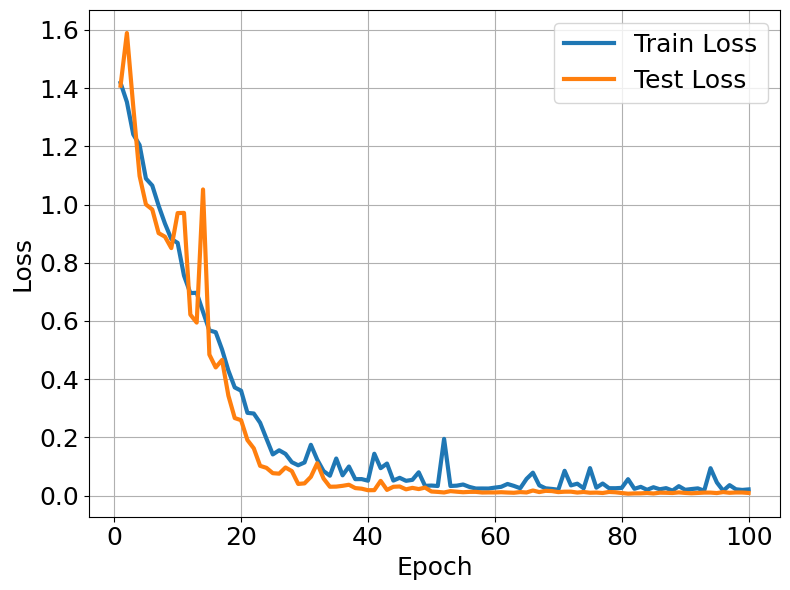

In [7]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

# ================== 图 1：Loss 曲线 ==================
plt.figure(figsize=(8, 6))

plt.plot(epochs_range, train_loss_history, label='Train Loss', linewidth=3)
plt.plot(epochs_range, test_loss_history, label='Test Loss', linewidth=3)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
# plt.title('Training and Testing Loss Curve')
plt.legend(loc='upper right', fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.savefig('loss_curve.pdf', format='pdf', dpi=300, bbox_inches='tight')
plt.show()

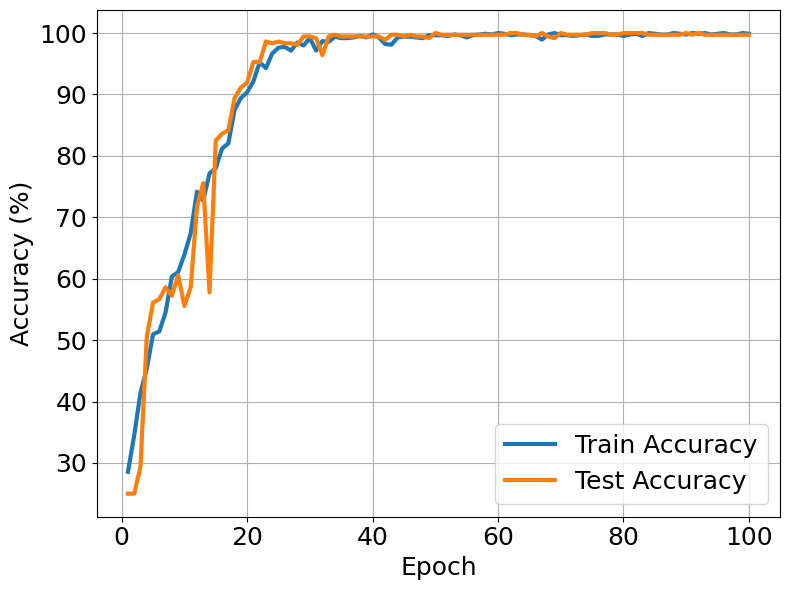

In [9]:
plt.figure(figsize=(8, 6))

plt.plot(epochs_range, train_acc_history, label='Train Accuracy', linewidth=3)
plt.plot(epochs_range, test_acc_history, label='Test Accuracy', linewidth=3)
plt.tick_params(axis='both', labelsize=18)
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.legend(loc='lower right', fontsize=18)
plt.grid(True)

plt.tight_layout()
plt.savefig('acc_curve.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:

# 从测试集提取样本
print("提取模型权重...")
weights = extract_foaw_features(model, test_loader, num_samples=100)


weights = weights.squeeze().numpy() 

# 创建阶次标签
a_values = np.arange(0, 1.1, 0.1)
order_labels = [f'{a:.1f}' for a in a_values]

# 计算平均权重
avg_weights = weights.mean(axis=0)

提取模型权重...


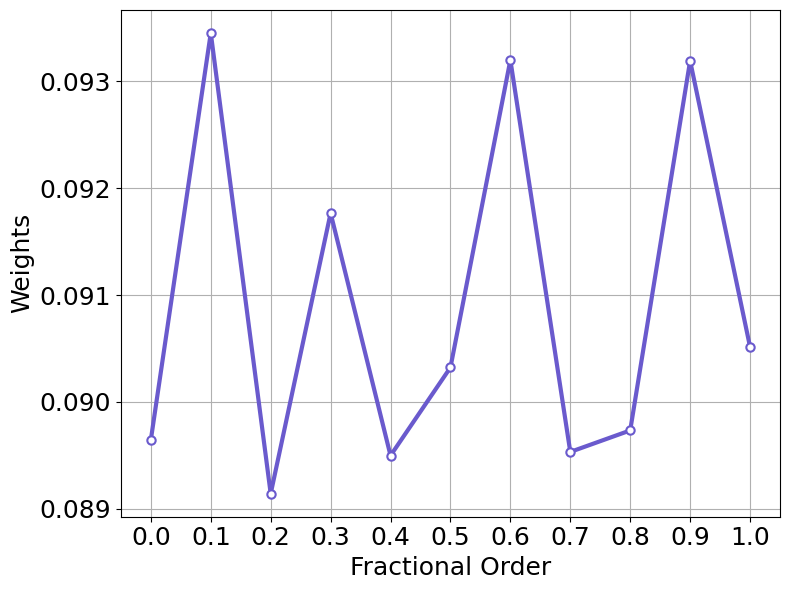

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# ===== 绘图 =====
plt.figure(figsize=(8, 6))

plt.plot(
    avg_weights,
    marker='o',
    linestyle='-',
    linewidth=3,
    markersize=6,
    color='#6A5ACD',
    markerfacecolor='white',
    markeredgewidth=1.5,
    markeredgecolor='#6A5ACD'
)

# ===== 坐标轴 =====
plt.xlabel('Fractional Order', fontsize=18)
plt.ylabel('Weights', fontsize=18)

plt.xticks(
    ticks=range(len(avg_weights)),
    labels=order_labels,
    fontsize=18,
    rotation=0
)
plt.yticks(fontsize=18)

plt.grid(True)


plt.tight_layout()
plt.savefig('weight.pdf', format='pdf', dpi=300)
plt.show()

In [ ]:
def intra_class_compactness(embeddings, labels):
    compactness = {}
    for c in np.unique(labels):
        pts = embeddings[labels == c]
        center = pts.mean(axis=0)
        compactness[c] = np.mean(np.linalg.norm(pts - center, axis=1))
    return compactness



from itertools import combinations

def inter_class_distance(embeddings, labels):
    centers = {
        c: embeddings[labels == c].mean(axis=0)
        for c in np.unique(labels)
    }
    distances = {}
    for (i, j) in combinations(centers.keys(), 2):
        distances[(i, j)] = np.linalg.norm(centers[i] - centers[j])
    return distances


import numpy as np
import matplotlib.patches as patches

def draw_confidence_ellipse(x, y, ax, n_std=1.5, **kwargs):
    """
    Draw covariance confidence ellipse for 2D points.
    """
    if x.size < 2:
        return

    cov = np.cov(x, y)
    if np.linalg.det(cov) <= 0:
        return

    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals, vecs = vals[order], vecs[:, order]

    angle = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    width, height = 2 * n_std * np.sqrt(vals)

    ellipse = patches.Ellipse(
        xy=(np.mean(x), np.mean(y)),
        width=width,
        height=height,
        angle=angle,
        alpha=0.15,
        **kwargs
    )

    ax.add_patch(ellipse)



Applying TSNE to input features...
Saved: ./tsne_results/tSNE_input.png


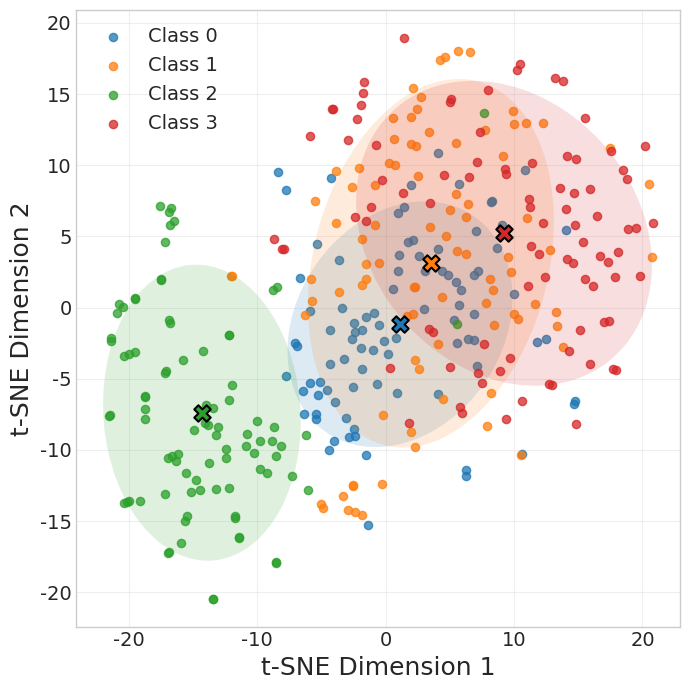

input: mean compactness=8.531, mean inter-class dist=14.217
Applying TSNE to initial_conv features...
Saved: ./tsne_results/tSNE_initial_conv.png


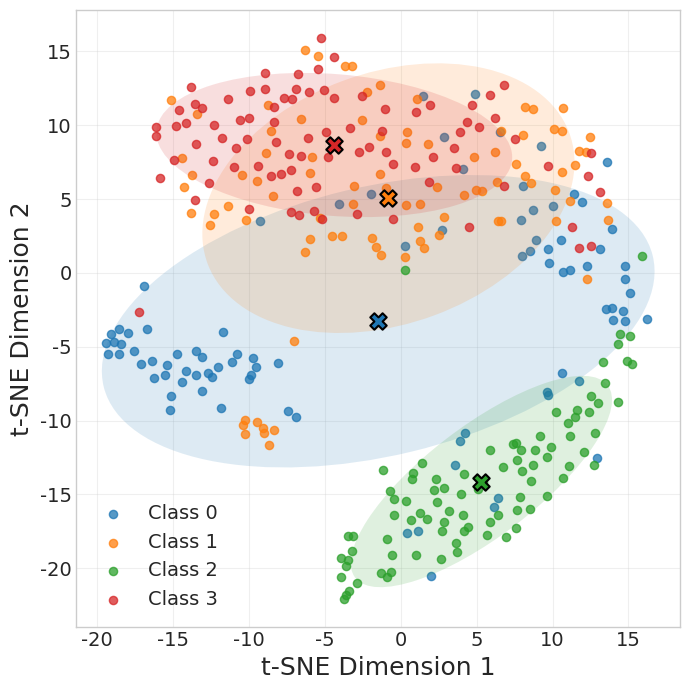

initial_conv: mean compactness=9.043, mean inter-class dist=13.903
Applying TSNE to block1 features...
Saved: ./tsne_results/tSNE_block1.png


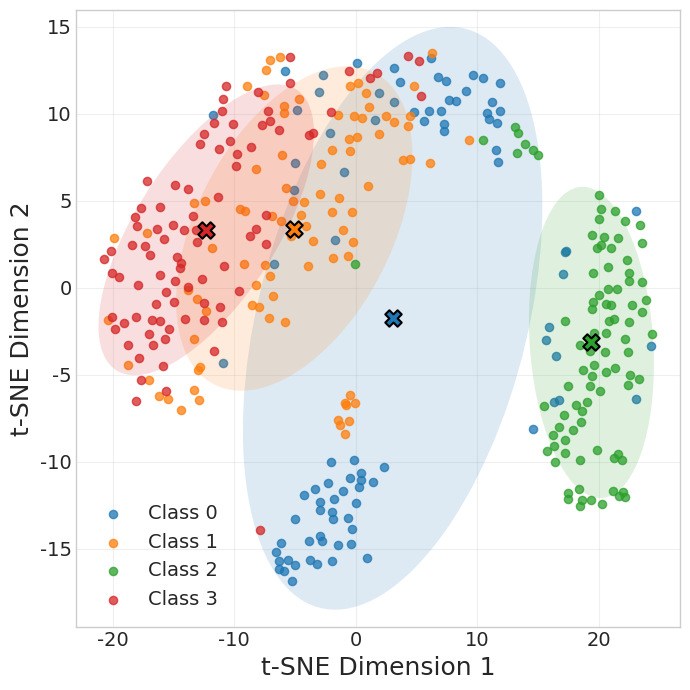

block1: mean compactness=8.592, mean inter-class dist=17.840
Applying TSNE to block2 features...
Saved: ./tsne_results/tSNE_block2.png


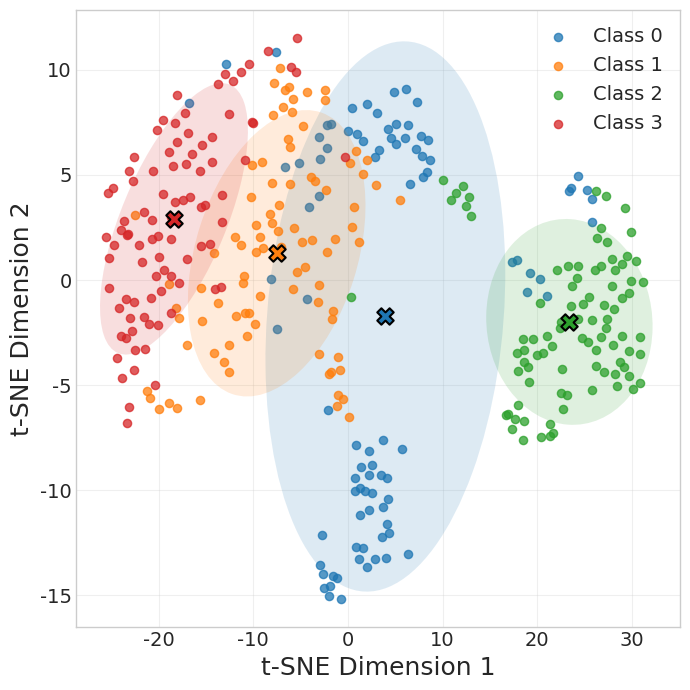

block2: mean compactness=7.446, mean inter-class dist=23.028
Applying TSNE to block3 features...
Saved: ./tsne_results/tSNE_block3.png


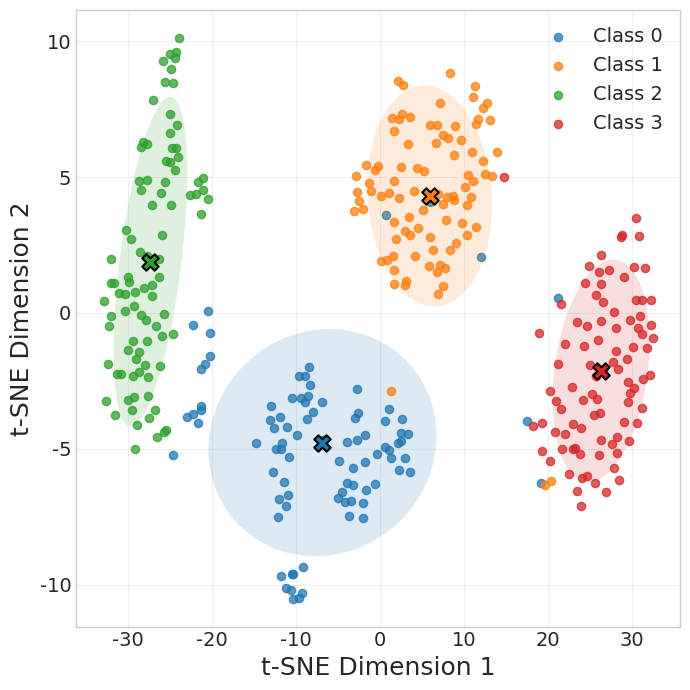

block3: mean compactness=5.336, mean inter-class dist=29.785
Applying TSNE to block4 features...
Saved: ./tsne_results/tSNE_block4.png


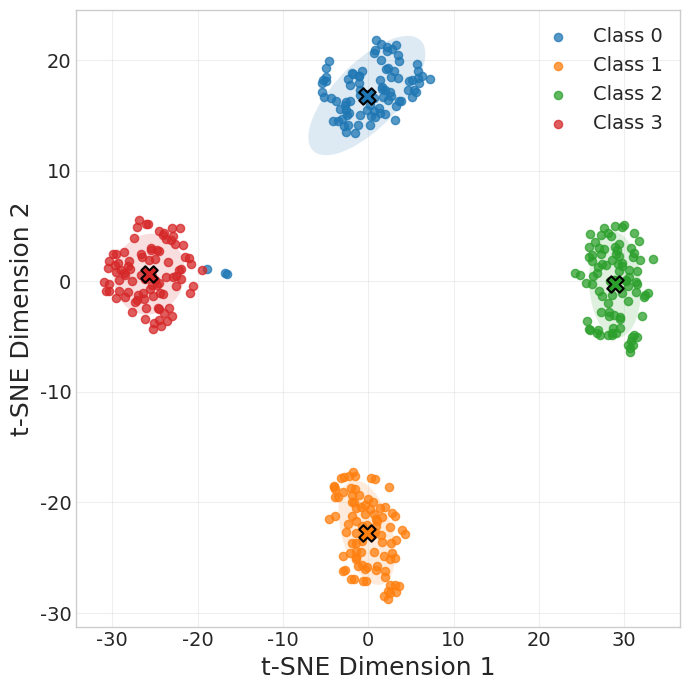

block4: mean compactness=3.686, mean inter-class dist=38.219
Applying TSNE to classifier features...
Saved: ./tsne_results/tSNE_classifier.png


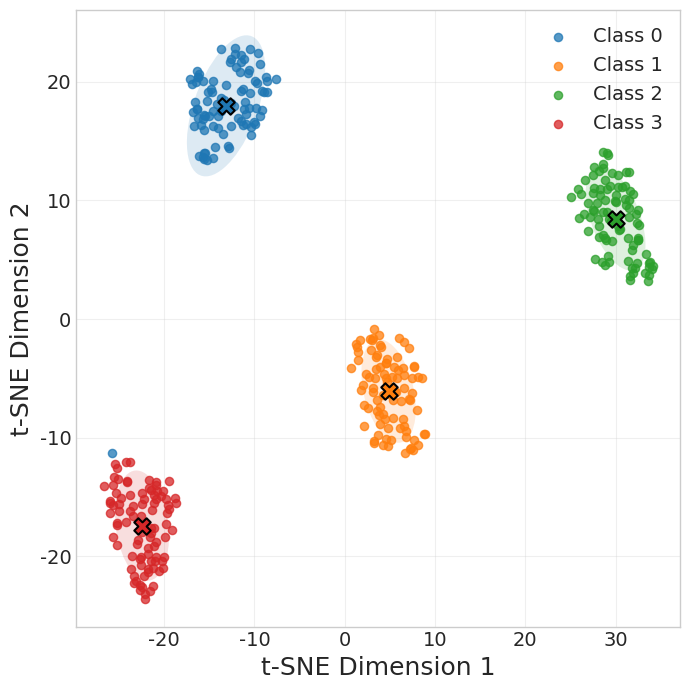

classifier: mean compactness=3.404, mean inter-class dist=37.979
Feature visualization complete!


In [ ]:
from sklearn.manifold import TSNE
import os

model = GADFMultiChannelNet(num_classes=num_cata, input_channels=X.shape[1])
model.load_state_dict(torch.load(best_model_path))
model.to(device)

# 测试模式
model.eval()

# 定义要提取特征的层
layers_to_extract = {
    'input': None,  # 原始输入
    'initial_conv': model.initial_conv,  # 初始特征提取后
    'block1': model.block1,  # block1后
    'block2': model.block2,  # block2后
    'block3': model.block3,  # block3后
    'block4': model.block4,  # block4后
    'classifier': model.classifier[0]  # 分类器前(flatten层)
}

# 创建字典存储各层的特征
features_dict = {name: [] for name in layers_to_extract}
labels_list = []

# 定义钩子函数
def get_hook_fn(name):
    def hook_fn(module, input, output):
        # 对于卷积层输出，需要进行全局池化减少维度
        if len(output.shape) == 4:
            # 使用平均池化将特征图转换为向量
            pooled = torch.nn.functional.adaptive_avg_pool2d(output, (1, 1))
            pooled = pooled.view(pooled.size(0), -1)  # 展平为 [batch_size, channels]
            features_dict[name].append(pooled.cpu().detach())
        else:
            features_dict[name].append(output.cpu().detach())
    return hook_fn

# 注册钩子
hooks = []
for name, layer in layers_to_extract.items():
    if layer is not None:  # 跳过input层
        hook = layer.register_forward_hook(get_hook_fn(name))
        hooks.append(hook)

# 提取特征
with torch.no_grad():
    for inputs, labels in test_loader:
        # 保存原始输入特征
        batch_size = inputs.size(0)
        flattened_inputs = inputs.view(batch_size, -1).cpu().detach()
        features_dict['input'].append(flattened_inputs)
        
        # 前向传播
        inputs = inputs.to(device)
        labels = labels.to(device)
        _ = model(inputs)
        
        # 保存标签
        labels_list.append(labels.cpu().numpy())

# 移除钩子
for hook in hooks:
    hook.remove()

# 合并批次的特征
for name in features_dict:
    if features_dict[name]:  # 检查列表非空
        features_dict[name] = torch.cat(features_dict[name], dim=0)
    else:
        print(f"Warning: No features collected for layer {name}")

# 合并标签
labels = np.concatenate(labels_list)

def apply_tsne_and_visualize(features, labels, layer_name):
    print(f"Applying TSNE to {layer_name} features...")

    # PCA 降维
    if features.shape[1] > 50:
        from sklearn.decomposition import PCA
        pca = PCA(n_components=50)
        features = pca.fit_transform(features.numpy())
    else:
        features = features.numpy()

    tsne = TSNE(
        n_components=2,
        random_state=42,
        perplexity=min(30, len(features) - 1)
    )
    tsne_results = tsne.fit_transform(features)

    fig, ax = plt.subplots(figsize=(7, 7))

    cmap = plt.cm.tab10

    for c in np.unique(labels):
        pts = tsne_results[labels == c]
        color = cmap(int(c) % 10)

        ax.scatter(
            pts[:, 0], pts[:, 1],
            s=35,
            alpha=0.75,
            color=color,
            label=f'Class {c}'
        )

        center = pts.mean(axis=0)
        ax.scatter(
            center[0], center[1],
            s=140,
            marker='X',
            color=color,    
            edgecolor='k',
            linewidth=1.5,
            zorder=5
        )

        # 置信椭圆
        draw_confidence_ellipse(
            pts[:, 0],
            pts[:, 1],
            ax,
            facecolor=color  
        )

    # ax.set_title(layer_name, fontsize=12)
    ax.tick_params(axis='both', labelsize=14)
    ax.set_xlabel('t-SNE Dimension 1', fontsize=18)
    ax.set_ylabel('t-SNE Dimension 2', fontsize=18)
    ax.legend(frameon=False, fontsize=14)
    ax.grid(alpha=0.3)
    plt.tight_layout()
    # ===== 保存 300 dpi PNG =====
    save_dir = './tsne_results'
    os.makedirs(save_dir, exist_ok=True)

    save_path = os.path.join(save_dir, f'tSNE_{layer_name}.png')
    fig.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"Saved: {save_path}")

    plt.show()
    plt.close(fig)

    # 定量指标
    compactness = intra_class_compactness(tsne_results, labels)
    separation = np.mean(
        list(inter_class_distance(tsne_results, labels).values())
    )

    print(
        f"{layer_name}: "
        f"mean compactness={np.mean(list(compactness.values())):.3f}, "
        f"mean inter-class dist={separation:.3f}"
    )


# 对每一层应用TSNE和可视化
for name, features in features_dict.items():
    if isinstance(features, torch.Tensor) and len(features) > 0:
        apply_tsne_and_visualize(features, labels, name)
    else:
        print(f"Skipping {name} - no valid features")

print("Feature visualization complete!")